In [46]:
import math
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from scipy.optimize import minimize
from math import sqrt

## Treinar KNN para estimar distâncias de pontos até as BSTs

In [47]:
bts = pd.read_csv('../data/bts.csv')
meds_train_alunos = pd.read_csv('../data/meds_train_alunos.csv')

In [48]:
def calculate_distances(row):
    point_coords = (row['lat'], row['lon'])
    distances = {}

    for _, bts_row in bts.iterrows():
        bts_coords = (bts_row['lat'], bts_row['lon'])
        distance = geodesic(bts_coords, point_coords).meters
        distances[f'bts_{bts_row["btsId"]}'] = distance

    return pd.Series(distances)

meds_train_alunos = pd.concat([meds_train_alunos, meds_train_alunos.apply(calculate_distances, axis=1)], axis=1)
meds_train_alunos.head()

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,...,indoor,bts_BTS_1_1,bts_BTS_1_2,bts_BTS_1_3,bts_BTS_2_1,bts_BTS_2_2,bts_BTS_2_3,bts_BTS_3_1,bts_BTS_3_2,bts_BTS_3_3
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,...,True,1368.718795,1368.718795,1368.718795,818.463128,818.463128,818.463128,706.791557,706.791557,706.791557
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,...,True,1368.092130,1368.092130,1368.092130,828.837721,828.837721,828.837721,695.452403,695.452403,695.452403
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,...,True,1337.092175,1337.092175,1337.092175,826.226925,826.226925,826.226925,684.496525,684.496525,684.496525
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,...,False,1140.876034,1140.876034,1140.876034,1671.832565,1671.832565,1671.832565,577.624625,577.624625,577.624625
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,...,True,1323.048839,1323.048839,1323.048839,825.918181,825.918181,825.918181,679.480041,679.480041,679.480041


In [49]:
X = meds_train_alunos[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y = meds_train_alunos[['bts_BTS_1_1', 'bts_BTS_1_2', 'bts_BTS_1_3','bts_BTS_2_1', 'bts_BTS_2_2', 'bts_BTS_2_3','bts_BTS_3_1', 'bts_BTS_3_2', 'bts_BTS_3_3']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [56]:
k = 3  # Número de vizinhos
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred_bts = knn.predict(X_test)

678 678


## Trilateração

In [57]:
def error(point, towers, distances):
    return sum([(sqrt((point[0] - towers[i][0])**2 + (point[1] - towers[i][1])**2) - distances[i])**2 for i in range(len(towers))])

def estimate_point_coordinates(distances, towers):
    x0 = [0, 0]    
    result = minimize(error, x0, args=(towers, distances), method='Nelder-Mead')
    return result.x

y_pred = []

for distances in y_pred_bts:
    closest_indices = sorted(range(len(distances)), key=lambda j: distances[j])[:3]
    closest_bts_coords = [(bts.iloc[j]['lat'], bts.iloc[j]['lon']) for j in closest_indices]

    point_lat, point_lon = estimate_point_coordinates(distances, closest_bts_coords)

    y_pred.append([point_lat, point_lon])


678


#### Dataframe com as informações de erros

In [69]:
df_with_error_info = y_test.copy()

test_indices = y_test.index
meds_test_for_testing_lines = meds_train_alunos.loc[test_indices]
df_with_error_info['lat'] = meds_test_for_testing_lines['lat']
df_with_error_info['lon'] = meds_test_for_testing_lines['lon']

df_with_error_info['lat_pred'] = [lat for [lat, _] in y_pred]
df_with_error_info['lon_pred'] = [lon for [_, lon] in y_pred]

df_with_error_info['lat_diff'] = df_with_error_info['lat'] - df_with_error_info['lat_pred']
df_with_error_info['lon_diff'] = df_with_error_info['lon'] - df_with_error_info['lon_pred']

In [70]:
one_degree = 30.87
one_kilometer = 1000

df_with_error_info['lat_diff_meters'] = df_with_error_info['lat_diff'] * one_degree * one_kilometer
df_with_error_info['lon_diff_meters'] = df_with_error_info['lon_diff'] * one_degree * one_kilometer

In [71]:
df_with_error_info['diff_meters'] = np.sqrt(df_with_error_info['lat_diff_meters']**2 + df_with_error_info['lon_diff_meters']**2)

## Resultados

In [67]:
y_pred_array = np.array(y_pred)

plt.figure(figsize=(10, 10))
plt.scatter(y_test['lon'], y_test['lat'], label='Real', alpha=0.5)
plt.scatter(y_pred_array[:, 1], y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

KeyError: 'lon'

<Figure size 1000x1000 with 0 Axes>

In [72]:
mean_diff_meters = df_with_error_info['diff_meters'].mean()
min_diff_meters = df_with_error_info['diff_meters'].min()
max_diff_meters = df_with_error_info['diff_meters'].max()
std_diff_meters = df_with_error_info['diff_meters'].std()

print(f"Média de erro: {mean_diff_meters:.2f} metros")
print(f"Mínimo de erro: {min_diff_meters:.2f} metros")
print(f"Máximo de erro: {max_diff_meters:.2f} metros")
print(f"Desvio padrão dos erros: {std_diff_meters:.2f} metros")

Média de erro: 38742052.75 metros
Mínimo de erro: 12871471.72 metros
Máximo de erro: 55085163.28 metros
Desvio padrão dos erros: 6876883.46 metros


#### Gráficos dos erros

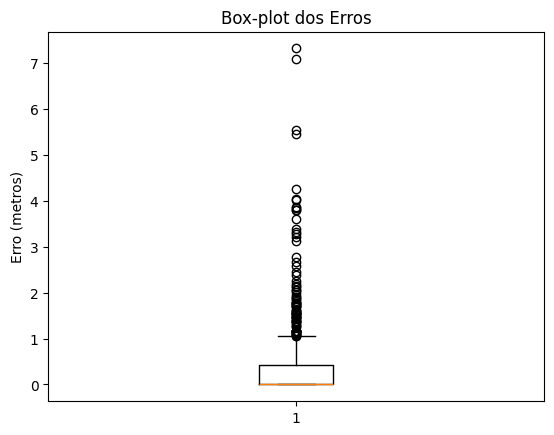

In [29]:
# Histograma e Box-Plot dos Erros
plt.boxplot(df_with_error_info['diff_meters'])
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()

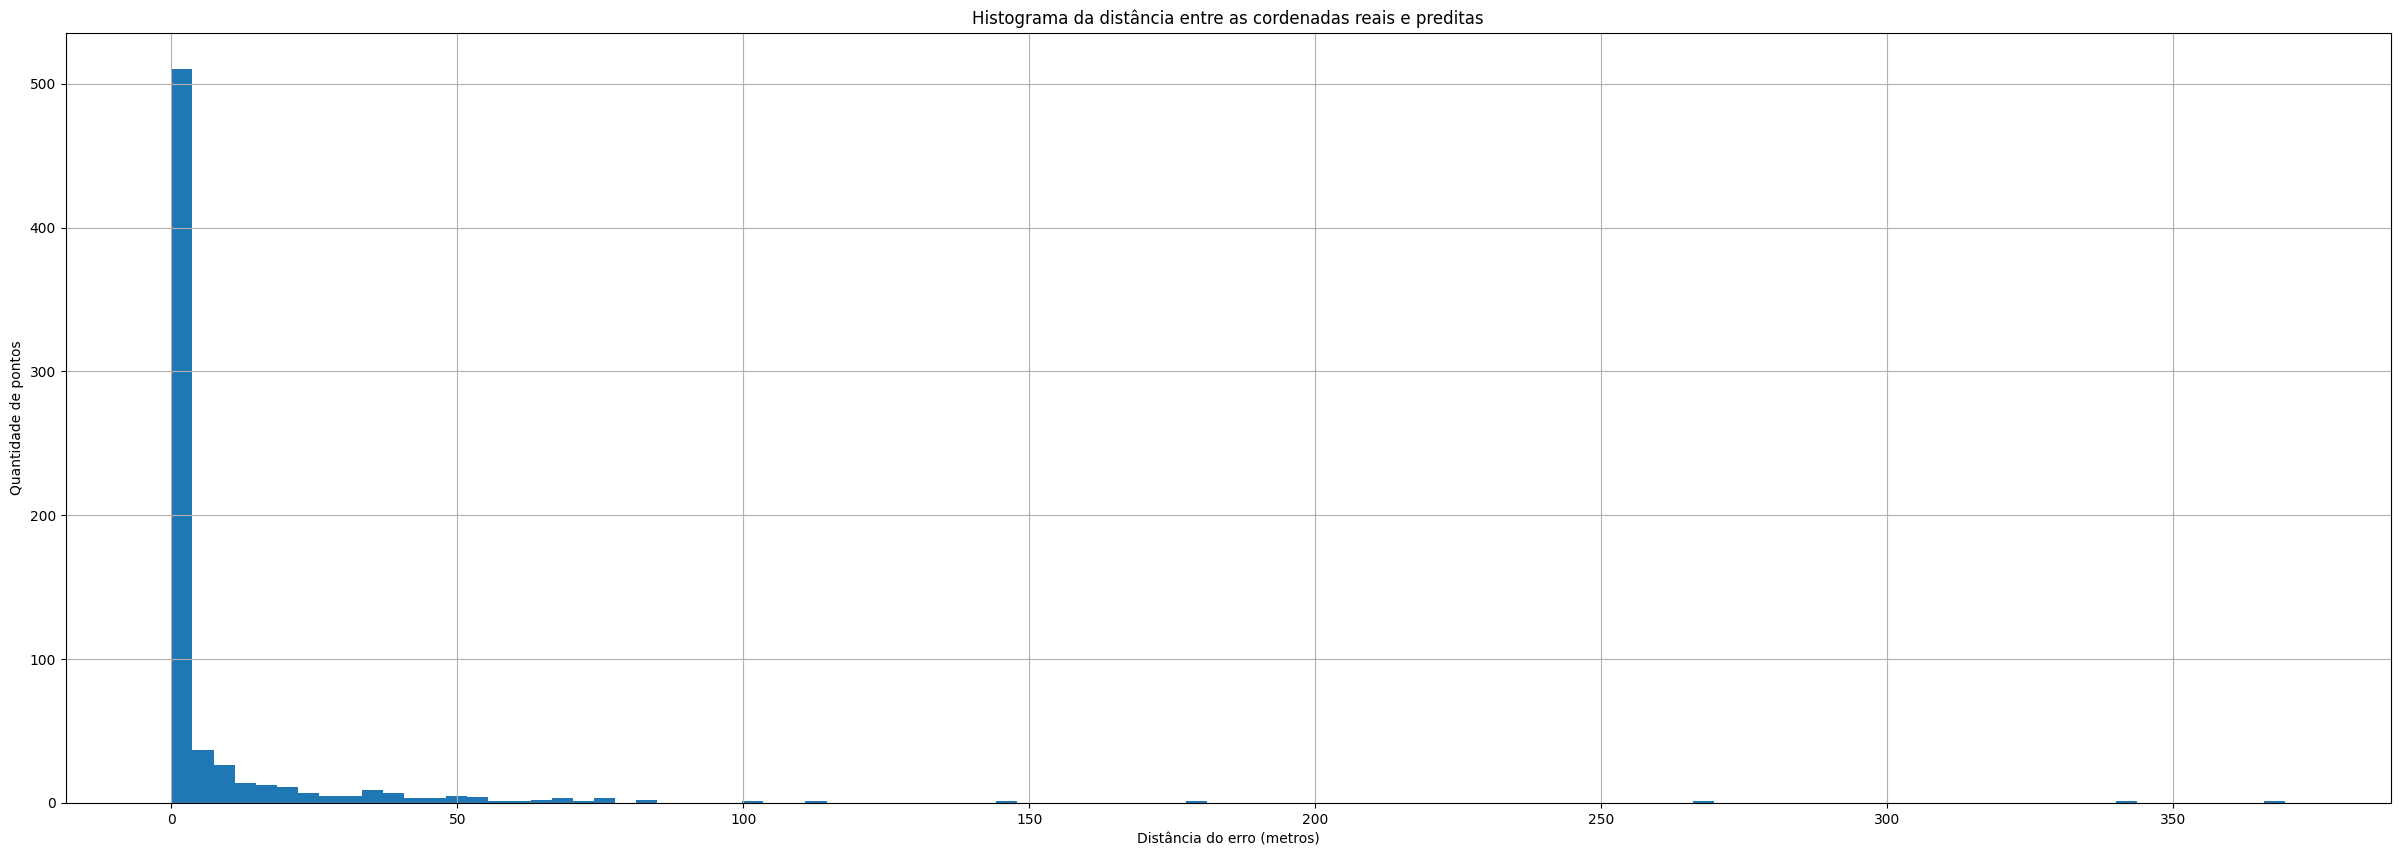

In [37]:
plt.figure(figsize=(30, 10))
plt.hist(df_with_error_info['diff_meters'], bins=100)

plt.xlabel('Distância do erro (metros)')
plt.ylabel('Quantidade de pontos')
plt.title('Histograma da distância entre as cordenadas reais e preditas')

plt.grid(True)
plt.show()

## Gerar submit file

In [30]:
meds_test = pd.read_csv('../data/meds_test_alunos.csv')

In [35]:
X_test = meds_test[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

y_pred_test = knn.predict(X_test)

In [36]:
submit_df = pd.DataFrame({'ponto_id': meds_test['ponto_id'], 'lat_pred': y_pred_test[:, 0], 'lon_pred': y_pred_test[:, 1]})
submit_df.to_csv('../submit_files/knn_submit_alunos.csv', index=False)